# LSTM To Predict Stock Prices

### by Luis A. Urso
### Version: 2.0 - Get Stock Prices / Data using YFINANCE library.

#### For this script we will get the stock prices of LLY from Yahoo Finance


In [6]:
## Code Parameters

## Window Analysis Parameters

win_start_date = "2023-03-30" # Start Date - need to be WIN_PERIODS value ahead of the start date into the Dataset
win_finish_date = "2024-02-29" # Finish Date - need to be WIN_PERIODS value behind the finish date into the Dataset 
win_periods = 6 # The Past Analysis Windows size.


In [1]:
## Load the Dataset 

import pandas as pd
import yfinance as yf

df = yf.download("LLY",start="2022-01-01",end="2024-03-11",progress=False)

df 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,274.410004,274.410004,267.059998,271.730011,264.983521,2621300
2022-01-04,269.000000,269.880005,263.579987,266.809998,260.185669,2340500
2022-01-05,268.160004,268.769989,260.420013,260.649994,254.178589,3004200
2022-01-06,260.100006,261.299988,255.460007,259.329987,252.891373,2863200
2022-01-07,259.739990,261.250000,256.709991,259.500000,253.057129,2245100
...,...,...,...,...,...,...
2024-03-04,796.440002,800.780029,786.159973,792.280029,792.280029,3855600
2024-03-05,785.309998,788.530029,769.280029,777.590027,777.590027,3168700
2024-03-06,784.289978,787.849976,774.000000,779.770020,779.770020,2518600


In [2]:
## Function to convert Date in String Format to DateTime Format 

import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)

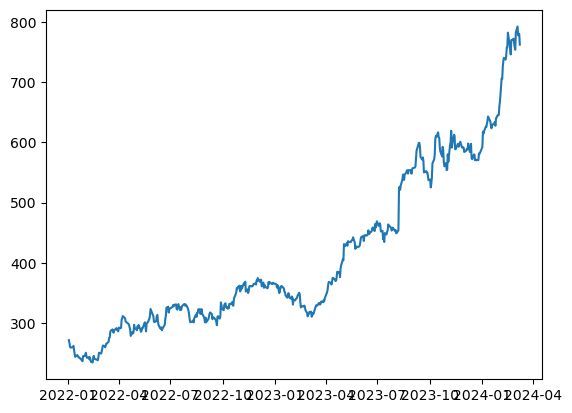

In [3]:
## Make a single plot to see the data

import matplotlib.pyplot as plt

plt.plot(df.index,df['Close'])

In [7]:
## Transform the DataSet into a Windowed Data Set 
## The n parameter is set to default as 3 and it represents the 3 previous period of the target date. 

import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=win_periods):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                win_start_date, 
                                win_finish_date, 
                                n=win_periods)
windowed_df

,Target Date,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2023-03-30,330.970001,332.640015,336.130005,334.600006,337.649994,335.869995,340.690002
1,2023-03-31,332.640015,336.130005,334.600006,337.649994,335.869995,340.690002,343.420013
2,2023-04-03,336.130005,334.600006,337.649994,335.869995,340.690002,343.420013,350.739990
3,2023-04-04,334.600006,337.649994,335.869995,340.690002,343.420013,350.739990,354.619995
4,2023-04-05,337.649994,335.869995,340.690002,343.420013,350.739990,354.619995,362.239990
...,...,...,...,...,...,...,...,...
226,2024-02-23,757.309998,757.780029,782.059998,755.659973,745.909973,769.640015,769.539978
227,2024-02-26,757.780029,782.059998,755.659973,745.909973,769.640015,769.539978,771.919983
228,2024-02-27,782.059998,755.659973,745.909973,769.640015,769.539978,771.919983,765.000000
229,2024-02-28,755.659973,745.909973,769.640015,769.539978,771.919983,765.000000,757.640015


In [8]:
## Function to convert the dataset to array extracting the date, X, and y 

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    ## Extract the date
    
    dates = df_as_np[:,0]
    
    ## Extract the X values (need to reshape to use in TensorFlow)
    
    middle_matrix = df_as_np[:,1:-1]
    X = middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))
    
    ## Extract the y 
    
    y = df_as_np[:,-1]
    
    
    return dates, X.astype(np.float32), y.astype(np.float32)


dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape 

((231,), (231, 6, 1), (231,))

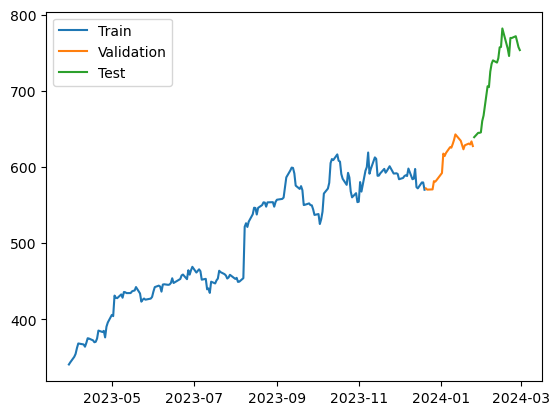

In [9]:
q_80 = int(len(dates) * .8) ## First 80% of the dataset
q_90 = int(len(dates) * .9) ## First 90% of the dataset

## Defining the trainin set 
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

## Defining the validation set
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

## Defining the test set
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

## Creates the model. The in the 1st layer the 3 is the size of the windows, and 1 is the quantity of variables of the model (univariate)
## in this case is only 1 because we only want the CLOSING, but it could be included more variavbles to predict. 
## The 2nd layer is the LSTM , need to be careful to avoid large numbers due overfit issues. 
## The 3rd and 4rd are dense layers with RELU activation functions
## the 5rd and last layer is a Dense with size 1, since we are predicting a single values

model = Sequential([layers.Input((win_periods, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])


## Loss funciton - we want to minimise the error (MSE)
## Optimizer is Adam that deals better with this type of problem we want to solve. 
## Metrics - mean absolute error what workes better with MSE 

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

ModuleNotFoundError: No module named 'tensorflow.keras'

6/6 [==============================] - 0s 826us/step


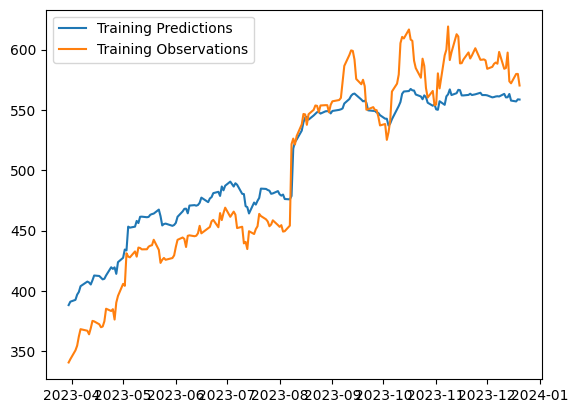

In [59]:
## Compares Training Data Performance x Training Predicted Performance

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 13ms/step


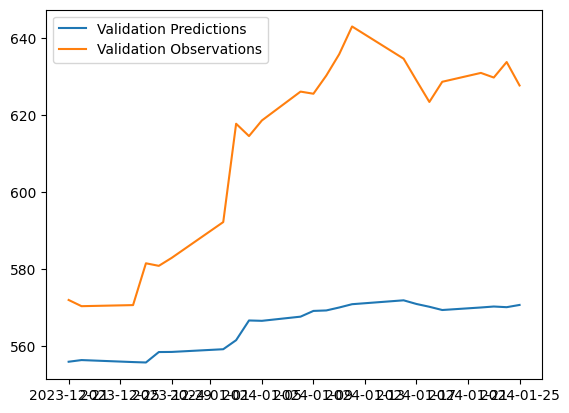

In [60]:
## Compares Validation Data Performance x Validation Predicted Performance

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 12ms/step


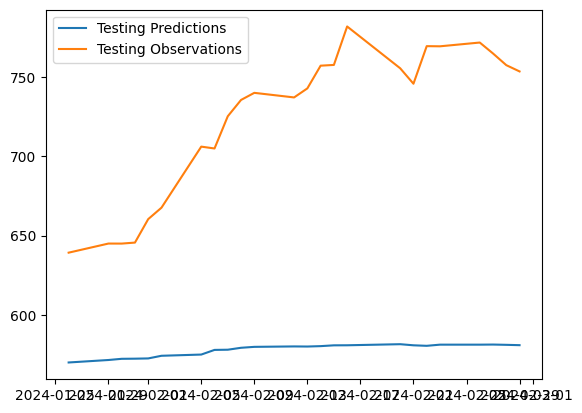

In [61]:
## Compares Test Data Performance x Test Predicted Performance

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

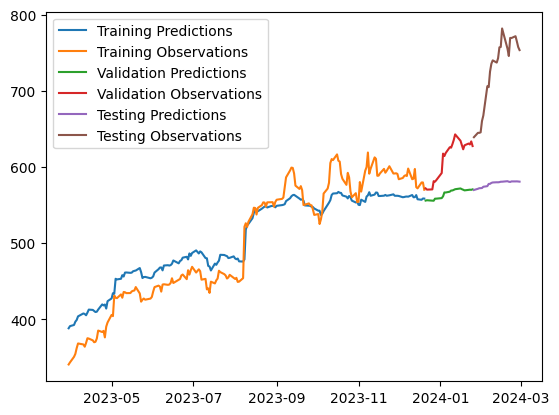

In [62]:
## Makes a Graph with all Observations x Predictions 

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

### Makes a Prediction for the Future using Recursive Prediction (previous predicted values is the parameter for the next predicted value)

In [63]:
## Makes the Recursive Prediction

from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


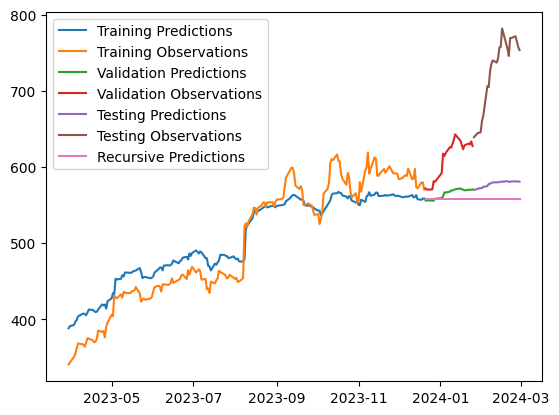

In [64]:
## Plot the Prediction Results 

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])